# German Cities - running and eating
#### My Project for IBM Data Science Professional Certificate

In [1]:

#Import the dependecies required.

import numpy as np # library to handle data in a vectorized manner
import re # required for string manipulation to extract latitude and longitude values

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#install lxml to read the wiki
!conda install lxml --yes
import lxml

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 
from sklearn import manifold, datasets  # Not used anymore

# cdist used to calculate inertia and determine best K
from scipy.spatial.distance import cdist 
from scipy.cluster import hierarchy # Will be used if extend analysis to hierarchical clustering
#from scipy import ndimage # Not used anymore
#from scipy.spatial import distance_matrix # Not used anymore

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - lxml


The following packages will be UPDATED:

    ca-certificates: 2020.6.20-hecda079_0     conda-forge --> 2020.6.24-0      
    certifi:         2020.6.20-py36h9f0ad1d_0 conda-forge --> 2020.6.20-py36_0 

The following packages will be DOWNGRADED:

    openssl:         1.1.1g-h516909a_1        conda-forge --> 1.1.1g-h7b6447c_0

Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be UPDATED:

    certifi:         2020.6.20-py36_0  --> 2020.6.20-py36h9f0ad1d_0 conda-forge
    openssl:         1.1.1g-h7b6447c_0 --> 1.1.1g-h516909a_1        conda-forge

The following packages will be DOWNGRADED:

    ca-certificates: 2020.6.24-0       --> 2020.6.20-hecda079_0

## Step 1 - Import and wrangle German city data
I am using a list of German cities on wikipedia. Here cities are defined as having a population greater than 100,000.  
https://en.wikipedia.org/wiki/List_of_cities_in_Germany_by_population

In [2]:
# Import German cities data from wikipedia
url='https://en.wikipedia.org/wiki/List_of_cities_in_Germany_by_population'
table = pd.read_html(url)
# select only the first table from the import
de_table = table[0]
de_table.head()

,2015rank,City,State,2015estimate,2011census,Change,2015land area,2015populationdensity,Location
0,1,Berlin,Berlin,3520031,3292365,+6.91%,891.68 km2344.28 sq mi,"3,948/km210,230/sq mi",52°31′N 13°23′E﻿ / ﻿52.517°N 13.383°E
1,2,Hamburg,Hamburg,1787408,1706696,+4.73%,755.3 km2291.6 sq mi,"2,366/km26,130/sq mi",53°33′N 10°0′E﻿ / ﻿53.550°N 10.000°E
2,3,Munich (München),Bavaria,1450381,1348335,+7.57%,310.7 km2120.0 sq mi,"4,668/km212,090/sq mi",48°8′N 11°34′E﻿ / ﻿48.133°N 11.567°E
3,4,Cologne (Köln),North Rhine-Westphalia,1060582,1005775,+5.45%,405.02 km2156.38 sq mi,"2,619/km26,780/sq mi",50°56′N 6°57′E﻿ / ﻿50.933°N 6.950°E
4,5,Frankfurt am Main,Hesse,732688,667925,+9.70%,248.31 km295.87 sq mi,"2,951/km27,640/sq mi",50°7′N 8°41′E﻿ / ﻿50.117°N 8.683°E


On inspection it can be seen that the columns of interest are the city name, its population as per 2015 estimate and the location

In [3]:
#Define the columns I want to keep and drop any column not in the list
my_columns = ['City','2015estimate','Location']
de_table = de_table.drop(columns=[col for col in de_table if col not in my_columns])
print(de_table.shape)
de_table.head() 

(79, 3)


,City,2015estimate,Location
0,Berlin,3520031,52°31′N 13°23′E﻿ / ﻿52.517°N 13.383°E
1,Hamburg,1787408,53°33′N 10°0′E﻿ / ﻿53.550°N 10.000°E
2,Munich (München),1450381,48°8′N 11°34′E﻿ / ﻿48.133°N 11.567°E
3,Cologne (Köln),1060582,50°56′N 6°57′E﻿ / ﻿50.933°N 6.950°E
4,Frankfurt am Main,732688,50°7′N 8°41′E﻿ / ﻿50.117°N 8.683°E


But I now need to extract the longitude and latitude data in decimal degree format from the Location column. So I will create a function to do this

In [4]:
# this function looks separates out all the separate components of the long string. 
# The decimal degree formats are in positions 4 and 5 and I just want to take the float and ignore any non-numerical characters
def extract_location(location):
    dd_location=re.findall(r"[-+]?\d*\.\d+|\d+", location)
    latitude=float(dd_location[4])
    longitude=float(dd_location[5])
    return (latitude,longitude)


In [5]:
# Iterate through the dataframe and split out lattitudes and longitudes for every city. Output tail to check that all looks good

latitudes=[]
longitudes=[]
for x in range(de_table.shape[0]):
    latitude,longitude = extract_location(de_table.loc[x,'Location'])
    latitudes.append(latitude)
    longitudes.append(longitude)

de_table['Latitude'] = latitudes
de_table['Longitude'] = longitudes


de_table.tail(10)

,City,2015estimate,Location,Latitude,Longitude
69,Bremerhaven,114025,53°33′N 8°35′E﻿ / ﻿53.550°N 8.583°E,53.550,8.583
70,Koblenz,112586,50°21′35″N 7°35′52″E﻿ / ﻿50.35972°N 7.59778°E,35.000,52.000
71,Bergisch Gladbach,111366,51°6′N 7°7′E﻿ / ﻿51.100°N 7.117°E,51.100,7.117
72,Jena,109527,50°55′38″N 11°35′10″E﻿ / ﻿50.92722°N 11.58611°E,35.000,10.000
73,Remscheid,109499,51°11′N 7°12′E﻿ / ﻿51.183°N 7.200°E,51.183,7.200
74,Erlangen,108336,49°35′N 11°1′E﻿ / ﻿49.583°N 11.017°E,49.583,11.017
75,Moers,104529,51°27′33″N 6°37′11″E﻿ / ﻿51.45917°N 6.61972°E,37.000,11.000
76,Siegen,102355,50°53′N 8°1′E﻿ / ﻿50.883°N 8.017°E,50.883,8.017
77,Hildesheim,101667,52°9′N 9°57′E﻿ / ﻿52.150°N 9.950°E,52.150,9.950
78,Salzgitter,101079,52°9′N 10°20′E﻿ / ﻿52.150°N 10.333°E,52.150,10.333


I noticed that at least one Location (Koblenz) does not meet the expected format used to extract the Latitude and Longitude values, so I want to check for any errors. I will do this by mapping the cities and visually checking them.

In [6]:
#I will take the first city (Berlin) as the origin for my map,
# and since I want to check for errors by trying to spot locations not in Germany, I will use zoom level 2 so that I can see the whole world map
latitude = de_table.loc[0, 'Latitude']
longitude = de_table.loc[0, 'Longitude']
map_germany = folium.Map(location=[latitude, longitude], zoom_start=2) 

# add markers to map
for city, lat, lng in zip(de_table['City'], de_table['Latitude'], de_table['Longitude']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_germany)
    
map_germany

Hmm, that doesn't look quite right.  
It can be seen from the map that six of the city location values are in error as they do not appear to be located in Germany.
These will be inspected and manually updated with correct values.

In [7]:
error_cities = {'Bottrop','Wolfsburg','Moers', 'Jena','Koblenz','Recklinghausen'}
for city in error_cities:
    city_index = de_table[de_table['City']==city].index[0]
    print("Index: {} City: {} Location: {} Latitude: {} Longitude: {}".format(
        city_index,
        city,
        de_table.loc[city_index,'Location'],
        de_table.loc[city_index,'Latitude'],
        de_table.loc[city_index,'Longitude']))
    

Index: 72 City: Jena Location: 50°55′38″N 11°35′10″E﻿ / ﻿50.92722°N 11.58611°E Latitude: 35.0 Longitude: 10.0
Index: 75 City: Moers Location: 51°27′33″N 6°37′11″E﻿ / ﻿51.45917°N 6.61972°E Latitude: 37.0 Longitude: 11.0
Index: 67 City: Recklinghausen Location: 51°35′6″N 7°9′43″E﻿ / ﻿51.58500°N 7.16194°E Latitude: 9.0 Longitude: 43.0
Index: 70 City: Koblenz Location: 50°21′35″N 7°35′52″E﻿ / ﻿50.35972°N 7.59778°E Latitude: 35.0 Longitude: 52.0
Index: 65 City: Bottrop Location: 51°31′29″N 6°55′22″E﻿ / ﻿51.52472°N 6.92278°E Latitude: 55.0 Longitude: 22.0
Index: 59 City: Wolfsburg Location: 52°25′23″N 10°47′14″E﻿ / ﻿52.42306°N 10.78722°E Latitude: 47.0 Longitude: 14.0


As can be seen the Location format is different to other cities (it has an extra " mark) which caused my location extracting function to return incorrect values so I will manually replace the Latitude and Longitude values with the correct ones

In [8]:
# create a dataframe with the corrections and update de_table. Check that updates are correct.
corrections=pd.DataFrame({'Latitude': [50.35972,50.92722,51.45917,51.58500,52.42306,51.52472],
                        'Longitude': [7.5977,11.58611,6.61972,7.16194,10.78722,6.92278]},index=[70,72,75,67,59,65]) 
de_table.update(corrections)
de_table.iloc[59:76,:]

,City,2015estimate,Location,Latitude,Longitude
59,Wolfsburg,124045,52°25′23″N 10°47′14″E﻿ / ﻿52.42306°N 10.78722°E,52.42306,10.78722
60,Offenbach am Main,123734,50°6′N 8°48′E﻿ / ﻿50.100°N 8.800°E,50.10000,8.80000
61,Ulm,122636,48°24′N 9°59′E﻿ / ﻿48.400°N 9.983°E,48.40000,9.98300
62,Heilbronn,122567,49°9′N 9°13′E﻿ / ﻿49.150°N 9.217°E,49.15000,9.21700
63,Pforzheim,122247,48°54′N 8°43′E﻿ / ﻿48.900°N 8.717°E,48.90000,8.71700
64,Göttingen,118914,51°32′N 9°56′E﻿ / ﻿51.533°N 9.933°E,51.53300,9.93300
65,Bottrop,117143,51°31′29″N 6°55′22″E﻿ / ﻿51.52472°N 6.92278°E,51.52472,6.92278
66,Trier,114914,49°45′N 6°38′E﻿ / ﻿49.750°N 6.633°E,49.75000,6.63300
67,Recklinghausen,114330,51°35′6″N 7°9′43″E﻿ / ﻿51.58500°N 7.16194°E,51.58500,7.16194
68,Reutlingen,114310,48°29′N 9°13′E﻿ / ﻿48.483°N 9.217°E,48.48300,9.21700


Comparing the Latitude and Longitude values to the Location text strings it can be seen that for the 6 cities that were incorrect before, these are now correct.

## Step 2 - Import and wrangle the Strava data
  
Strava is an app that allows runners and cyclists to upload their activities (recorded using GPS devices) and compare their performance on 'Segments' which are popular stretches. Using the Strava API I can retrieve the 10 most popular segments for a location. I will use these to get information about whether the cities in my list have flat or hilly runs and whether the segments are long or short.

In [9]:
#@ hidden cell

# TODO - refresh every six hours

# Set Strava api credentials
STRAVA_ACCESS_TOKEN = 'c298addca779e2ca06fe9f11fd2988a6691c686e'

### Strava API
Strava requires an access token which is valid only for 6 hours. Before running this notebook the access token needs to be refreshed and updated

### Explanation of Strava boundaries
In order to explore Strave segments, the Strava API requires South-West and North-East boundaries to be provided. The API will then return the top 10 segments within theset boundaries.
I have chosen to define the boundaries as ± 0.1 deg latitude and ± 0.16 deg longitude.
Note: 1deg latitude = approx 110km, 1deg longitude at 50deg = approx 70km (this will vary for each city as its longitude varies)

First I need to calculate the Strava boundaries for each city and add these as new colums to my table

In [10]:
# Calculate Strava boundaries for each city and add as new columns to the table 
# 1deg latitude = approx 110km therefore 0.1deg = 11km, 1deg longitude at 50deg = approx 70km 0.16deg for longitude 

de_runs = pd.DataFrame(de_table[['City','Latitude','Longitude']])

de_runs['SW_lat'] = (de_table['Latitude'].astype(float))-0.05
de_runs['SW_long'] = (de_table['Longitude'].astype(float))-0.08
de_runs['NE_lat'] = (de_table['Latitude'].astype(float))+0.05
de_runs['NE_long'] = (de_table['Longitude'].astype(float))+0.08


print(de_runs.shape)
de_runs.head()


(79, 7)


,City,Latitude,Longitude,SW_lat,SW_long,NE_lat,NE_long
0,Berlin,52.517,13.383,52.467,13.303,52.567,13.463
1,Hamburg,53.550,10.000,53.500,9.920,53.600,10.080
2,Munich (München),48.133,11.567,48.083,11.487,48.183,11.647
3,Cologne (Köln),50.933,6.950,50.883,6.870,50.983,7.030
4,Frankfurt am Main,50.117,8.683,50.067,8.603,50.167,8.763


Next I will explore the Strava data using Stuttgart as an example.  
I will check that the boundaries look reasonable by drawing a line on the map which goes from the SW to the NE boundary

In [11]:
# Define boundaries for Stuttgart
stut_index = de_runs.index[de_runs['City']=='Stuttgart'][0]
bounds_all=de_runs.iloc[stut_index]

latitude=bounds_all[['Latitude']][0]
longitude=bounds_all[['Longitude']][0]
NE_lat = bounds_all[['NE_lat']][0]
NE_long = bounds_all[['NE_long']][0]
SW_lat = bounds_all[['SW_lat']][0]
SW_long = bounds_all[['SW_long']][0]

stut_boundary=((SW_lat,SW_long),(NE_lat,NE_long))
print(stut_boundary)

# draw line on map to check that boundary NE and SW corners look to be reasonable
map_stuttgart = folium.Map(location=[latitude, longitude], zoom_start=10) 
folium.PolyLine(stut_boundary).add_to(map_stuttgart)
    
map_stuttgart

((48.733000000000004, 9.103), (48.833, 9.263))


Now I use these boundaries to retrieve the segments for Stuttgart

In [12]:
# Explore Strava segment data using Stuttgart. Define the URL and convert the results from JSON to a dataframe
activity_type='running'
url = 'https://www.strava.com/api/v3/segments/explore?bounds={},{},{},{}&activity_type={}&access_token={}'.format( 
            SW_lat,SW_long,NE_lat,NE_long,
            activity_type,
            STRAVA_ACCESS_TOKEN)

results = requests.get(url).json()["segments"]
df=pd.DataFrame(results)
df.head()

,avg_grade,climb_category,climb_category_desc,distance,elev_difference,elevation_profile,end_latlng,id,local_legend_enabled,name,points,resource_state,starred,start_latlng
0,-0.2,0,NC,1202.5,7.4,https://d3o5xota0a1fcr.cloudfront.net/charts/2...,"[48.789847, 9.189775]",5917542,True,Schlosspark Tree-lined Straightaway (short),utyhHicdw@Ld@FFHVVPBL`@l@L^NLFT@^t@x@`@j@b@z@B...,2,False,"[48.797072, 9.20133]"
1,-0.0,0,NC,5491.2,22.5,https://d3o5xota0a1fcr.cloudfront.net/charts/Q...,"[48.757107, 9.111523]",2211716,True,Bärenseen Start Ost,g}qhHwqrv@?FDLSx@JPFFDTGFENKt@KFC`@Fr@On@@RGLC...,2,False,"[48.757485, 9.111482]"
2,4.2,0,NC,666.2,28.8,https://d3o5xota0a1fcr.cloudfront.net/charts/L...,"[48.765411, 9.131832]",5327887,True,birkenkopf-1,cishHwtvv@A~@K|@UtAAp@CXg@xAKNMFq@Mo@i@u@c@OMI...,2,False,"[48.764504, 9.132444]"
3,-0.4,0,NC,1366.2,10.5,https://d3o5xota0a1fcr.cloudfront.net/charts/X...,"[48.796674, 9.203674]",5516640,True,Unterer Schloßgarten,kbxhHo_bw@[e@Qw@GMQQ]UUWGGI[[k@EGSAIEa@i@WQSIE...,2,False,"[48.789029, 9.19048]"
4,10.1,1,4,1367.3,138.9,https://d3o5xota0a1fcr.cloudfront.net/charts/E...,"[48.764297, 9.1431024]",3144977,True,Hasenbergsteige Wannenstr to top,k{shHmf|v@d@jDLxANt@XbCFLBXhA~IJ`@RzBRfAJ|@`@t...,2,False,"[48.7674254, 9.1608782]"


In [13]:
# There are a lot of columns that I'm not interested in so I will delete these
df.drop(['resource_state','climb_category_desc','points','starred','local_legend_enabled','elevation_profile'],axis=1, inplace=True)
df.head()

,avg_grade,climb_category,distance,elev_difference,end_latlng,id,name,start_latlng
0,-0.2,0,1202.5,7.4,"[48.789847, 9.189775]",5917542,Schlosspark Tree-lined Straightaway (short),"[48.797072, 9.20133]"
1,-0.0,0,5491.2,22.5,"[48.757107, 9.111523]",2211716,Bärenseen Start Ost,"[48.757485, 9.111482]"
2,4.2,0,666.2,28.8,"[48.765411, 9.131832]",5327887,birkenkopf-1,"[48.764504, 9.132444]"
3,-0.4,0,1366.2,10.5,"[48.796674, 9.203674]",5516640,Unterer Schloßgarten,"[48.789029, 9.19048]"
4,10.1,1,1367.3,138.9,"[48.764297, 9.1431024]",3144977,Hasenbergsteige Wannenstr to top,"[48.7674254, 9.1608782]"


Now, I want to categorise segments as hilly or flat and long or short.  
I've defined hilly as anything with an upwards or downwards gradient of more than 2%.
I've defined long as anything longer than 1km (1000m)

In [14]:
# want to classify segments as hilly or flat (hilly = <>2%) and long or short (long>1000m)

# First the gradient
bins = [-100,-2.0, 2.0,100]
labels = ['hilly_descent','flat','hilly_ascent']
df['steep'] = pd.cut(df['avg_grade'], bins=bins, labels=labels)
# since I don't care whether the hill is up or down, I combine hilly_ascent and hilly_descent and call them all hilly
df['steep'].replace({'hilly_descent':'hilly','hilly_ascent':'hilly'},inplace=True)

# Now the length
bins = [0,1000,100000]
labels = ['short','long']
df['length'] = pd.cut(df['distance'], bins=bins, labels=labels)

# add city back in
df['City'] = 'Stuttgart'
df

,avg_grade,climb_category,distance,elev_difference,end_latlng,id,name,start_latlng,steep,length,City
0,-0.2,0,1202.5,7.4,"[48.789847, 9.189775]",5917542,Schlosspark Tree-lined Straightaway (short),"[48.797072, 9.20133]",flat,long,Stuttgart
1,-0.0,0,5491.2,22.5,"[48.757107, 9.111523]",2211716,Bärenseen Start Ost,"[48.757485, 9.111482]",flat,long,Stuttgart
2,4.2,0,666.2,28.8,"[48.765411, 9.131832]",5327887,birkenkopf-1,"[48.764504, 9.132444]",hilly,short,Stuttgart
3,-0.4,0,1366.2,10.5,"[48.796674, 9.203674]",5516640,Unterer Schloßgarten,"[48.789029, 9.19048]",flat,long,Stuttgart
4,10.1,1,1367.3,138.9,"[48.764297, 9.1431024]",3144977,Hasenbergsteige Wannenstr to top,"[48.7674254, 9.1608782]",hilly,long,Stuttgart
5,-0.0,0,2049.1,10.0,"[48.826766, 9.210974]",6968915,Hofener Straße,"[48.816708, 9.229351]",flat,long,Stuttgart
6,0.3,0,1017.0,4.9,"[48.798856, 9.213412]",15988091,Wasenlauf - 1 km,"[48.791412, 9.220733]",flat,long,Stuttgart
7,0.1,0,1345.0,8.5,"[48.738302, 9.146558]",9602455,Road to Sonnenberg,"[48.733892, 9.130295]",flat,long,Stuttgart
8,-1.9,0,601.4,11.2,"[48.733293, 9.24941]",10220544,Ruiter Kurve,"[48.735564, 9.242444]",flat,short,Stuttgart
9,3.4,0,751.8,27.2,"[48.797446, 9.113226]",10806892,Neuer Friedhof -> Hasenbrünnle,"[48.802683, 9.116911]",hilly,short,Stuttgart


Now I need to do this for all the cities in my list.  I will first retrieve all the strava data for the cities

In [15]:
 # Retrive Strava data for all cities
df=pd.DataFrame()
activity_type='running'
for n in range(de_runs.shape[0]-0):
    print(de_runs.loc[n,'City'])
    url = 'https://www.strava.com/api/v3/segments/explore?bounds={},{},{},{}&activity_type={}&access_token={}'.format( 
            de_runs.loc[n,'SW_lat'],
            de_runs.loc[n,'SW_long'],
            de_runs.loc[n,'NE_lat'],
            de_runs.loc[n,'NE_long'],
            activity_type,
            STRAVA_ACCESS_TOKEN)
    results = requests.get(url).json()["segments"]  
    results_df=pd.DataFrame(results)
    results_df['City'] = de_runs.loc[n,'City']
    results_df.drop(['resource_state','climb_category_desc','points','starred','local_legend_enabled','elevation_profile'],axis=1, inplace=True)
    df=df.append(results_df)

print(df.shape)

Berlin
Hamburg
Munich (München)
Cologne (Köln)
Frankfurt am Main
Stuttgart
Düsseldorf
Dortmund
Essen
Leipzig
Bremen
Dresden
Hanover (Hannover)
Nuremberg (Nürnberg)
Duisburg
Bochum
Wuppertal
Bielefeld
Bonn
Münster
Karlsruhe
Mannheim
Augsburg
Wiesbaden
Gelsenkirchen
Mönchengladbach
Braunschweig
Chemnitz
Kiel
Aachen
Halle (Saale)
Magdeburg
Freiburg im Breisgau
Krefeld
Lübeck
Oberhausen
Erfurt
Mainz
Rostock
Kassel
Hagen
Hamm
Saarbrücken
Mülheim an der Ruhr
Potsdam
Ludwigshafen am Rhein
Oldenburg
Leverkusen
Osnabrück
Solingen
Heidelberg
Herne
Neuss
Darmstadt
Paderborn
Regensburg
Ingolstadt
Würzburg
Fürth
Wolfsburg
Offenbach am Main
Ulm
Heilbronn
Pforzheim
Göttingen
Bottrop
Trier
Recklinghausen
Reutlingen
Bremerhaven
Koblenz
Bergisch Gladbach
Jena
Remscheid
Erlangen
Moers
Siegen
Hildesheim
Salzgitter
(790, 9)


Now add in the steep and length categorisations

In [16]:
# Add the categorisations for hilly/flat, long/short

bins = [-100,-2.0, 2.0,100]
labels = ['hilly_descent','flat','hilly_ascent']
df['steep'] = pd.cut(df['avg_grade'], bins=bins, labels=labels)
df['steep'].replace({'hilly_descent':'hilly','hilly_ascent':'hilly'},inplace=True)

bins = [0,1000,100000]
labels = ['short','long']
df['length'] = pd.cut(df['distance'], bins=bins, labels=labels)

# Reset the index
df.reset_index(drop=True, inplace=True)

print(df.shape)
df.tail()


(790, 11)


,avg_grade,climb_category,distance,elev_difference,end_latlng,id,name,start_latlng,City,steep,length
785,7.6,0,751.0,57.0,"[52.109623, 10.302423]",20617438,Bonbon RUN 😤,"[52.113001, 10.294642]",Salzgitter,hilly,short
786,10.5,0,588.0,62.0,"[52.115246, 10.321811]",18071090,Bollchenberg RUN 😤,"[52.119447, 10.326586]",Salzgitter,hilly,short
787,8.1,0,430.7,34.7,"[52.119279, 10.301399]",10680318,Gaspumpenstation,"[52.122683, 10.304128]",Salzgitter,hilly,short
788,0.0,0,1259.8,4.0,"[52.152425, 10.295763]",7317117,Fredenberg Feldweg,"[52.14654, 10.28319]",Salzgitter,flat,long
789,4.1,0,1438.5,59.1,"[52.123415, 10.323935]",9697586,Hasselberg Asphaltlauf,"[52.133648, 10.327484]",Salzgitter,hilly,long


Now I need to use the onehot encoding from previous lab to summarise types of run for each city as percentages.

In [17]:
# Run onehot encoding on the table to get totals for each city. Present these as mean values.

runs_steep_onehot = pd.get_dummies(df[['steep']], prefix="", prefix_sep="")
runs_length_onehot = pd.get_dummies(df[['length']], prefix="", prefix_sep="")

runs_onehot=pd.merge(runs_steep_onehot,runs_length_onehot,how='outer',right_index=True, left_index=True)
runs_onehot['City']=df['City']
runs_onehot.tail()
runs_germany=runs_onehot.groupby(['City']).mean()
print(runs_germany.shape)
runs_germany.head()

(79, 4)


,flat,hilly,short,long
City,,,,
Aachen,0.7,0.3,0.3,0.7
Augsburg,1.0,0.0,0.5,0.5
Bergisch Gladbach,0.3,0.7,0.7,0.3
Berlin,1.0,0.0,0.5,0.5
Bielefeld,0.4,0.6,0.6,0.4


## Step 3 - Import and wrangle Foursquare data
Foursquare provides data on different venues within a location. I will use the API to get venue details for each of the German Cities and then as I am only interested in eateries, I will identify these venues and ignore the others.

In [21]:
# @hidden_cell
    
# Set foursquare api credentials
FOURSQUARE_CLIENT_ID = 'QGR0UTHF3ICBJKQA4PTVHG3YVRIBHRX0ZS41P1QCZQX4UYXZ' # your Foursquare ID
FOURSQUARE_CLIENT_SECRET = '2RO55RSBT0EWUPQRRQ31NZAYCPDNVPFXXSIQ0QUKNSOO0EDQ' # your Foursquare Secret
FOURSQUARE_VERSION = '20180605' # Foursquare API version


First I will reuse the two functions defined in the earlier lab to explore venues within a city and to extract the venue category labels 

In [44]:
#Using function created in lab to get venues in a City
def getNearbyVenues(names, latitudes, longitudes, radius=5000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            FOURSQUARE_VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',            
                  'Venue Category']
    
    return(nearby_venues)

In [45]:
# Use the get_category_type function from the Foursquare lab.
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Use these two functions to create a table of venues for all of the cities in my list

In [46]:
# Run the above function on each City in Germany and create a new dataframe called de_city_venues.

de_city_venues = getNearbyVenues(names=de_table['City'], 
                                   latitudes=de_table['Latitude'],
                                   longitudes=de_table['Longitude']
                                 )
print(de_city_venues.shape)
de_city_venues.head()


Berlin
Hamburg
Munich (München)
Cologne (Köln)
Frankfurt am Main
Stuttgart
Düsseldorf
Dortmund
Essen
Leipzig
Bremen
Dresden
Hanover (Hannover)
Nuremberg (Nürnberg)
Duisburg
Bochum
Wuppertal
Bielefeld
Bonn
Münster
Karlsruhe
Mannheim
Augsburg
Wiesbaden
Gelsenkirchen
Mönchengladbach
Braunschweig
Chemnitz
Kiel
Aachen
Halle (Saale)
Magdeburg
Freiburg im Breisgau
Krefeld
Lübeck
Oberhausen
Erfurt
Mainz
Rostock
Kassel
Hagen
Hamm
Saarbrücken
Mülheim an der Ruhr
Potsdam
Ludwigshafen am Rhein
Oldenburg
Leverkusen
Osnabrück
Solingen
Heidelberg
Herne
Neuss
Darmstadt
Paderborn
Regensburg
Ingolstadt
Würzburg
Fürth
Wolfsburg
Offenbach am Main
Ulm
Heilbronn
Pforzheim
Göttingen
Bottrop
Trier
Recklinghausen
Reutlingen
Bremerhaven
Koblenz
Bergisch Gladbach
Jena
Remscheid
Erlangen
Moers
Siegen
Hildesheim
Salzgitter
(6928, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berlin,52.517,13.383,Butter Lindner,52.517879,13.380450,Gourmet Shop
1,Berlin,52.517,13.383,Brandenburger Tor,52.516247,13.377786,Monument / Landmark
2,Berlin,52.517,13.383,Dussmann das KulturKaufhaus,52.518343,13.388965,Bookstore
3,Berlin,52.517,13.383,Dussmann English Bookshop,52.518223,13.389239,Bookstore
4,Berlin,52.517,13.383,Купол Pейхстага (Reichstagskuppel),52.518549,13.376099,Scenic Lookout


As before, use one hot encoding to summarise the number of each category of venue for each city

In [47]:
# one hot encoding

de_city_onehot = pd.get_dummies(de_city_venues[['Venue Category']], prefix="", prefix_sep="")
test_onehot=de_city_onehot

# add City column back to dataframe
de_city_onehot['City'] = de_city_venues['City']

# move City column to the first column
fixed_columns = [de_city_onehot.columns[-1]] + list(de_city_onehot.columns[:-1])  
de_city_onehot = de_city_onehot[fixed_columns]

print(de_city_onehot.shape)
de_city_onehot.head()

(6928, 348)


,City,ATM,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Campground,Canal,Canal Lock,Candy Store,Capitol Building,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Gym,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Currywurst Joint,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Forest,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Inn,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Kurdish Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Light Rail Station,Lighthouse,Liquor Store,Locksmith,Lounge,Market,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monastery,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,National Park,Nature Preserve,Neighborhood,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Outlet Store,Paintball Field,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Café,Pet Store,Photography Studio,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Port,Portuguese Restaurant,Pub,Public Art,RV Park,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Schnitzel Restaurant,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping 

I'm only interested in places where I can eat. Many are obvious as the category name includes 'Restaurant' but some like 'Coffee Shop' are not so obvious. I will get a list of all the categories with their counts. Then I can check what other ones I need to add in to my list of eateries to inlcude.

In [48]:
# create count of categories to check any that are eateries and not called '... Restaurant'
print(de_city_onehot.sum(axis='rows'))

City                               BerlinBerlinBerlinBerlinBerlinBerlinBerlinBerl...
ATM                                                                                2
Advertising Agency                                                                 1
Afghan Restaurant                                                                  1
African Restaurant                                                                 8
Airport                                                                            2
American Restaurant                                                               13
Amphitheater                                                                       1
Aquarium                                                                           2
Arcade                                                                             1
Argentinian Restaurant                                                             9
Art Gallery                                                      

In [49]:
# Create a list of venue categories that are eateries as defined by including 'Restaurant' in the title or being in my list of other eateries.
venue_categories = de_city_onehot.columns
other_eateries = ['Bakery','Beer Garden','Bistro','Breakfast Spot','Burger Joint','Café','Coffee Shop','Gastropub', 'Ice Cream Shop','Pizza Place','Sandwich Place','Steakhouse','Trattoria/Osteria']
eateries=[]
for venue in venue_categories:
    if 'Restaurant' in venue:
        eateries.append(venue)
    elif (venue in other_eateries): 
        eateries.append(venue)
print(eateries)

de_city_onehot=de_city_onehot[eateries]

# add city column back to dataframe
de_city_onehot['City'] = de_city_venues['City']

# move city column to the first column
fixed_columns = [de_city_onehot.columns[-1]] + list(de_city_onehot.columns[:-1])
de_city_onehot = de_city_onehot[fixed_columns]

de_city_onehot.head()    

['Afghan Restaurant', 'African Restaurant', 'American Restaurant', 'Argentinian Restaurant', 'Asian Restaurant', 'Austrian Restaurant', 'Bakery', 'Bavarian Restaurant', 'Beer Garden', 'Belgian Restaurant', 'Bistro', 'Brazilian Restaurant', 'Breakfast Spot', 'Burger Joint', 'Café', 'Caribbean Restaurant', 'Caucasian Restaurant', 'Chinese Restaurant', 'Coffee Shop', 'Comfort Food Restaurant', 'Doner Restaurant', 'Dumpling Restaurant', 'Dutch Restaurant', 'Eastern European Restaurant', 'Falafel Restaurant', 'Fast Food Restaurant', 'Franconian Restaurant', 'French Restaurant', 'Gastropub', 'German Restaurant', 'Greek Restaurant', 'Grilled Meat Restaurant', 'Halal Restaurant', 'Ice Cream Shop', 'Indian Chinese Restaurant', 'Indian Restaurant', 'Indonesian Restaurant', 'Israeli Restaurant', 'Italian Restaurant', 'Japanese Restaurant', 'Jewish Restaurant', 'Kebab Restaurant', 'Korean Restaurant', 'Kurdish Restaurant', 'Latin American Restaurant', 'Mediterranean Restaurant', 'Mexican Restauran

,City,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Bakery,Bavarian Restaurant,Beer Garden,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Coffee Shop,Comfort Food Restaurant,Doner Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Franconian Restaurant,French Restaurant,Gastropub,German Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mongolian Restaurant,Moroccan Restaurant,Persian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Sandwich Place,Scandinavian Restaurant,Schnitzel Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swabian Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Berlin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Berlin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Berlin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Berlin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Berlin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
# group by city
germany_grouped = de_city_onehot.groupby('City').mean().reset_index()
print(germany_grouped.shape) 
germany_grouped


(79, 77)


,City,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Bakery,Bavarian Restaurant,Beer Garden,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Coffee Shop,Comfort Food Restaurant,Doner Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Franconian Restaurant,French Restaurant,Gastropub,German Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mongolian Restaurant,Moroccan Restaurant,Persian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Sandwich Place,Scandinavian Restaurant,Schnitzel Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swabian Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Aachen,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.030000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.020000,0.050000,0.00,0.000000,0.010000,0.030000,0.00,0.000000,0.00,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.000000,0.060000,0.010000,0.000000,0.000000,0.030000,0.00,0.000000,0.00,0.00,0.050000,0.000000,0.00,0.00,0.01000,0.00,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.020000,0.00,0.00,0.00,0.010000,0.000000,0.00,0.00,0.000000,0.01,0.00,0.000000,0.010000,0.010000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.010000,0.000000
1,Augsburg,0.00,0.00,0.010000,0.000000,0.000000,0.00,0.020000,0.010000,0.040000,0.00,0.000000,0.000000,0.000000,0.020000,0.070000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.010000,0.000000,0.00,0.010000,0.010000,0.050000,0.020000,0.000000,0.000000,0.000000,0.00,0.020000,0.00,0.00,0.070000,0.010000,0.00,0.00,0.00000,0.00,0.000000,0.000000,0.020000,0.000000,0.010000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.010000,0.00,0.00,0.000000,0.050000,0.010000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.020000,0.030000,0.000000,0.010000
2,Bergisch Gladbach,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.176471,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.029412,0.176471,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.029412,0.000000,0.00,0.00,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.088235,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.029412,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
3,Berlin,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.020000,0.00,0.010000,0.000000,0.080000,0.00,0.000000,0.00,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.000000,0.00,0.00,0.020000,0.000000,0.00,0.00,0.00000,0.00,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.010000,0.00,0.00,0.01,0.000000,0.020000,0.00,0.01,0.010000,0.00,0.00,0.010000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.010000,0.010000
4,Bielefeld,0.00,0.00,0.000000,0.014493,0.000000,0.00,0.014493,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.014493,0.043478,0.00,0.000000,0.014493,0.014493,0.00,0.000000,0.00,0.000000,0.00

## Step 4 - Merge the Strava and Foursquare data

Now I can merge the Strava and the Foursquare data into a single table that will be used for my Cluster analysis

In [51]:
germany_combined=pd.merge(germany_grouped,runs_germany,how='outer',right_on='City', left_on='City')
print(germany_combined.shape)
germany_combined


(79, 81)


,City,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Bakery,Bavarian Restaurant,Beer Garden,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Coffee Shop,Comfort Food Restaurant,Doner Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Franconian Restaurant,French Restaurant,Gastropub,German Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mongolian Restaurant,Moroccan Restaurant,Persian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Sandwich Place,Scandinavian Restaurant,Schnitzel Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swabian Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,flat,hilly,short,long
0,Aachen,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.030000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.020000,0.050000,0.00,0.000000,0.010000,0.030000,0.00,0.000000,0.00,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.000000,0.060000,0.010000,0.000000,0.000000,0.030000,0.00,0.000000,0.00,0.00,0.050000,0.000000,0.00,0.00,0.01000,0.00,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.020000,0.00,0.00,0.00,0.010000,0.000000,0.00,0.00,0.000000,0.01,0.00,0.000000,0.010000,0.010000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.010000,0.000000,0.7,0.3,0.3,0.7
1,Augsburg,0.00,0.00,0.010000,0.000000,0.000000,0.00,0.020000,0.010000,0.040000,0.00,0.000000,0.000000,0.000000,0.020000,0.070000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.010000,0.000000,0.00,0.010000,0.010000,0.050000,0.020000,0.000000,0.000000,0.000000,0.00,0.020000,0.00,0.00,0.070000,0.010000,0.00,0.00,0.00000,0.00,0.000000,0.000000,0.020000,0.000000,0.010000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.010000,0.00,0.00,0.000000,0.050000,0.010000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.020000,0.030000,0.000000,0.010000,1.0,0.0,0.5,0.5
2,Bergisch Gladbach,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.176471,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.029412,0.176471,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.029412,0.000000,0.00,0.00,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.088235,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.029412,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.3,0.7,0.7,0.3
3,Berlin,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.020000,0.00,0.010000,0.000000,0.080000,0.00,0.000000,0.00,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.000000,0.00,0.00,0.020000,0.000000,0.00,0.00,0.00000,0.00,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.010000,0.00,0.00,0.01,0.000000,0.020000,0.00,0.01,0.010000,0.00,0.00,0.010000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.010000,0.010000,1.0,0.0,0.5,0.5
4,Bielefeld,0.00,0.00,0.000000,0.014493,0.000000,0.00,0.014493,0.000000,0.000000,0.00,0.000000,0.000000,0.000

## Step 5 - Cluster analysis
Finally I can perform cluster analysis on my list of German cities, with information about places to eat and segments to run on

In [31]:
%matplotlib inline

In [52]:
# create a new table withouth 'City' column to be used for the clustering
germany_grouped_clustering = germany_combined.drop('City', 1)
germany_grouped_clustering.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Bakery,Bavarian Restaurant,Beer Garden,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Coffee Shop,Comfort Food Restaurant,Doner Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Franconian Restaurant,French Restaurant,Gastropub,German Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mongolian Restaurant,Moroccan Restaurant,Persian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Sandwich Place,Scandinavian Restaurant,Schnitzel Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swabian Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,flat,hilly,short,long
0,0.0,0.0,0.00,0.000000,0.0,0.0,0.030000,0.00,0.00,0.0,0.00,0.0,0.0,0.020000,0.050000,0.0,0.00,0.010000,0.030000,0.0,0.0,0.0,0.0,0.0,0.01,0.000000,0.0,0.000000,0.000000,0.060000,0.010000,0.0,0.0,0.03,0.0,0.00,0.0,0.0,0.050000,0.00,0.0,0.0,0.01,0.0,0.0,0.020000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.020000,0.0,0.0,0.00,0.010000,0.000000,0.0,0.00,0.00,0.01,0.0,0.000000,0.010000,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.01,0.00,0.7,0.3,0.3,0.7
1,0.0,0.0,0.01,0.000000,0.0,0.0,0.020000,0.01,0.04,0.0,0.00,0.0,0.0,0.020000,0.070000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.01,0.000000,0.0,0.010000,0.010000,0.050000,0.020000,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.070000,0.01,0.0,0.0,0.00,0.0,0.0,0.000000,0.020000,0.000000,0.01,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.01,0.00,0.0,0.000000,0.050000,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.03,0.00,0.01,1.0,0.0,0.5,0.5
2,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.000000,0.176471,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.029412,0.176471,0.000000,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.029412,0.00,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.088235,0.000000,0.0,0.00,0.00,0.00,0.0,0.000000,0.000000,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.3,0.7,0.7,0.3
3,0.0,0.0,0.00,0.000000,0.0,0.0,0.020000,0.00,0.00,0.0,0.02,0.0,0.0,0.000000,0.020000,0.0,0.01,0.000000,0.080000,0.0,0.0,0.0,0.0,0.0,0.01,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.02,0.0,0.00,0.0,0.0,0.020000,0.00,0.0,0.0,0.00,0.0,0.0,0.010000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.010000,0.0,0.0,0.01,0.000000,0.020000,0.0,0.01,0.01,0.00,0.0,0.010000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.01,0.01,1.0,0.0,0.5,0.5
4,0.0,0.0,0.00,0.014493,0.0,0.0,0.014493,0.00,0.00,0.0,0.00,0.0,0.0,0.014493,0.043478,0.0,0.00,0.014493,0.014493,0.0,0.0,0.0,0.0,0.0,0.00,0.014493,0.0,0.014493,0.000000,0.014493,0.014493,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.043478,0.00,0.0,0.0,0.00,0.0,0.0,0.043478,0.014493,0.028986,0.00,0.0,0.0,0.0,0.028986,0.0,0.0,0.00,0.028986,0.014493,0.0,0.00,0.00,0.00,0.0,0.014493,0.014493,0.014493,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.4,0.6,0.6,0.4


I need to decide what value to use for my K clusters, so will determine the best K using elbow analysis

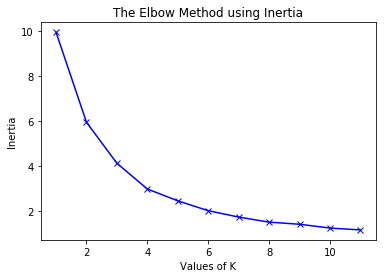

In [53]:
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,12) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(germany_grouped_clustering) 
    kmeanModel.fit(germany_grouped_clustering)

    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(germany_grouped_clustering, kmeanModel.cluster_centers_,'euclidean'),axis=1)) / germany_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_
    
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()
    

The elbow is at K=4 so I will use this for the cluster analysis

In [54]:
kclusters=4
feature_mtx=germany_combined.drop('City',axis=1)
agglom = AgglomerativeClustering(n_clusters = kclusters, linkage = 'complete')
agglom.fit(feature_mtx)
agglom.labels_

array([2, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2,
       1, 0, 0, 0, 3, 0, 0, 0, 0, 3, 2, 0, 0, 2, 3, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       1, 0, 1, 3, 0, 1, 2, 0, 2, 1, 2, 0, 2])

In [55]:
germany_combined['cluster'] = agglom.labels_
germany_combined.head(10)

,City,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Bakery,Bavarian Restaurant,Beer Garden,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Coffee Shop,Comfort Food Restaurant,Doner Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Franconian Restaurant,French Restaurant,Gastropub,German Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mongolian Restaurant,Moroccan Restaurant,Persian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Sandwich Place,Scandinavian Restaurant,Schnitzel Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swabian Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,flat,hilly,short,long,cluster
0,Aachen,0.0,0.0,0.000000,0.000000,0.00,0.00,0.030000,0.00,0.00,0.0,0.00,0.0,0.0,0.020000,0.050000,0.0,0.000000,0.010000,0.030000,0.0,0.00,0.0,0.000000,0.0,0.01,0.000000,0.0,0.000000,0.000000,0.060000,0.010000,0.0,0.00,0.03,0.0,0.00,0.0,0.0,0.050000,0.000000,0.0,0.00,0.01,0.0,0.0,0.020000,0.000000,0.000000,0.00,0.00,0.0,0.0,0.020000,0.0,0.0,0.00,0.010000,0.000000,0.0,0.00,0.00,0.01,0.0,0.000000,0.010000,0.010000,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.01,0.00,0.7,0.3,0.3,0.7,2
1,Augsburg,0.0,0.0,0.010000,0.000000,0.00,0.00,0.020000,0.01,0.04,0.0,0.00,0.0,0.0,0.020000,0.070000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.0,0.01,0.000000,0.0,0.010000,0.010000,0.050000,0.020000,0.0,0.00,0.00,0.0,0.02,0.0,0.0,0.070000,0.010000,0.0,0.00,0.00,0.0,0.0,0.000000,0.020000,0.000000,0.01,0.00,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.01,0.00,0.0,0.000000,0.050000,0.010000,0.0,0.0,0.00,0.0,0.0,0.00,0.020000,0.030000,0.00,0.01,1.0,0.0,0.5,0.5,0
2,Bergisch Gladbach,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.000000,0.176471,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.029412,0.176471,0.000000,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.029412,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.00,0.088235,0.000000,0.0,0.00,0.00,0.00,0.0,0.000000,0.000000,0.029412,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.00,0.3,0.7,0.7,0.3,1
3,Berlin,0.0,0.0,0.000000,0.000000,0.00,0.00,0.020000,0.00,0.00,0.0,0.02,0.0,0.0,0.000000,0.020000,0.0,0.010000,0.000000,0.080000,0.0,0.00,0.0,0.000000,0.0,0.01,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.02,0.0,0.00,0.0,0.0,0.020000,0.000000,0.0,0.00,0.00,0.0,0.0,0.010000,0.000000,0.000000,0.00,0.00,0.0,0.0,0.010000,0.0,0.0,0.01,0.000000,0.020000,0.0,0.01,0.01,0.00,0.0,0.010000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.01,0.01,1.0,0.0,0.5,0.5,0
4,Bielefeld,0.0,0.0,0.000000,0.014493,0.00,0.00,0.014493,0.00,0.00,0.0,0.00,0.0,0.0,0.014493,0.043478,0.0,0.000000,0.014493,0.014493,0.0,0.00,0.0,0.000000,0.0,0.00,0.014493,0.0,0.014493,0.000000,0.014493,0.014493,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.043478,0.000000,0.0,0.00,0.00,0.0,0.0,0.043478,0.014493,0.028986,0.00,0.00,0.0,0.0,0.028986,0.0,0.0,0.00,0.028986,0.014493,0.0,0.00,0.00,0.00,0.0,0.014493,0.014493,0.014493,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.00,0.4,0.6,0.6,0.4,1
5,Bochum,0.0,0.0,0.020000,0.000000,0.02,0.01,0.070000,0.00,0.00,0.0,0.00,0

Merge the latitude and longitude data back into the table with clusters

In [56]:
new_germany_combined = pd.merge(germany_combined,de_table,how='inner',right_on='City', left_on='City')
print(new_germany_combined.shape)
new_germany_combined.head()

(79, 86)


,City,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,Bakery,Bavarian Restaurant,Beer Garden,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Café,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Coffee Shop,Comfort Food Restaurant,Doner Restaurant,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Franconian Restaurant,French Restaurant,Gastropub,German Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mongolian Restaurant,Moroccan Restaurant,Persian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Sandwich Place,Scandinavian Restaurant,Schnitzel Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swabian Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,flat,hilly,short,long,cluster,2015estimate,Location,Latitude,Longitude
0,Aachen,0.0,0.0,0.00,0.000000,0.0,0.0,0.030000,0.00,0.00,0.0,0.00,0.0,0.0,0.020000,0.050000,0.0,0.00,0.010000,0.030000,0.0,0.0,0.0,0.0,0.0,0.01,0.000000,0.0,0.000000,0.000000,0.060000,0.010000,0.0,0.0,0.03,0.0,0.00,0.0,0.0,0.050000,0.00,0.0,0.0,0.01,0.0,0.0,0.020000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.020000,0.0,0.0,0.00,0.010000,0.000000,0.0,0.00,0.00,0.01,0.0,0.000000,0.010000,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.01,0.00,0.7,0.3,0.3,0.7,2,245885,50°47′N 6°5′E﻿ / ﻿50.783°N 6.083°E,50.783,6.083
1,Augsburg,0.0,0.0,0.01,0.000000,0.0,0.0,0.020000,0.01,0.04,0.0,0.00,0.0,0.0,0.020000,0.070000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.01,0.000000,0.0,0.010000,0.010000,0.050000,0.020000,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.070000,0.01,0.0,0.0,0.00,0.0,0.0,0.000000,0.020000,0.000000,0.01,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.01,0.00,0.0,0.000000,0.050000,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.03,0.00,0.01,1.0,0.0,0.5,0.5,0,286374,48°22′N 10°54′E﻿ / ﻿48.367°N 10.900°E,48.367,10.900
2,Bergisch Gladbach,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.000000,0.176471,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.029412,0.176471,0.000000,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.029412,0.00,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.088235,0.000000,0.0,0.00,0.00,0.00,0.0,0.000000,0.000000,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.3,0.7,0.7,0.3,1,111366,51°6′N 7°7′E﻿ / ﻿51.100°N 7.117°E,51.100,7.117
3,Berlin,0.0,0.0,0.00,0.000000,0.0,0.0,0.020000,0.00,0.00,0.0,0.02,0.0,0.0,0.000000,0.020000,0.0,0.01,0.000000,0.080000,0.0,0.0,0.0,0.0,0.0,0.01,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.02,0.0,0.00,0.0,0.0,0.020000,0.00,0.0,0.0,0.00,0.0,0.0,0.010000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.010000,0.0,0.0,0.01,0.000000,0.020000,0.0,0.01,0.01,0.00,0.0,0.010000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.01,0.01,1.0,0.0,0.5,0.5,0,3520031,52°31′N 13°23′E﻿ / ﻿52.517°N 13.383°E,52.517,13.383
4,Bielefeld,0.0,0.0,0.00,0.014493,0.0,0.0,0.014493,0.00,0.00,0.0,0.00,0.0,0.0,0.014493,0.043478,0.0,0.00,0.014493,0.014493,0.0,0.0,0.0,0.0,0.0,0.00,0.014493,0.0,0.014493,0.000000,0.014493,0.014493,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.043478,0.00,0.0,0.0,0.00,0.0,0.0,0.043478,0.014493,0.028986,0.00,0.0,0.0,0.0,0.028986,0.0,0.0,0.00,0.028986,0.014493,0.0,0.00,0.00,0.00,0.0,0.014493,0.014493,0.014493,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0

Now to visualise the clusters on the map of Germany

In [61]:
# Visualize the resulting clusters

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, city, cluster in zip(new_germany_combined['Latitude'], new_germany_combined['Longitude'], new_germany_combined['City'], new_germany_combined['cluster']):
    label = folium.Popup(str(city) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

And finally in order to provide a description of the clusters, I will use the definition from previous lab to identify the Top 5 types of eatery in each city and present that with the Strava running segment data


In [58]:
# First, let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = germany_grouped['City']

for ind in np.arange(germany_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(germany_grouped.iloc[ind, :], num_top_venues)

# merge back in the run 'steep' and 'length' attributes and the clusters
cities_venues_sorted=pd.merge(cities_venues_sorted,runs_germany,how='inner',right_on='City', left_on='City')
cities_venues_sorted['Cluster'] = agglom.labels_

# move clusters towards the left and sort on clusters
col = cities_venues_sorted.pop("Cluster")
cities_venues_sorted.insert(1, col.name, col)
cities_venues_sorted.sort_values(by=['Cluster'])


,City,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,flat,hilly,short,long
39,Kiel,0,Café,Coffee Shop,Asian Restaurant,Burger Joint,Restaurant,0.8,0.2,0.5,0.5
33,Herne,0,Fast Food Restaurant,Bakery,Ice Cream Shop,German Restaurant,Greek Restaurant,0.8,0.2,0.6,0.4
34,Hildesheim,0,Café,German Restaurant,Restaurant,Indian Restaurant,Mexican Restaurant,0.6,0.4,0.6,0.4
67,Rostock,0,Restaurant,Café,Greek Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,0.9,0.1,0.9,0.1
37,Karlsruhe,0,Italian Restaurant,Café,Ice Cream Shop,Vegetarian / Vegan Restaurant,Pizza Place,0.9,0.1,0.9,0.1
38,Kassel,0,German Restaurant,Café,Italian Restaurant,Coffee Shop,Turkish Restaurant,0.6,0.4,0.7,0.3
77,Wuppertal,0,Café,Italian Restaurant,Coffee Shop,Restaurant,Burger Joint,0.6,0.4,0.7,0.3
41,Krefeld,0,Café,Bakery,Greek Restaurant,Italian Restaurant,Burger Joint,0.9,0.1,0.5,0.5
42,Leipzig,0,Café,Coffee Shop,German Restaurant,Restaurant,Burger Joint,0.9,0.1,0.8,0.2
43,Leverkusen,0,German Restaurant,Ice Cream Shop,Italian Restaurant,Bakery,Fast Food Restaurant,1.0,0.0,0.5,0.5


In conclusion we could describe the categories as follows
Cluster 0 = lots of cafes, very flat running  
Cluster 1 = German restaurants, mainly short runs  
Cluster 2 = German and Italian restaurants, hilly and short runs  
Cluster 3 = even mix of hilly/flat and long/short runs